In [86]:
import firebase_admin
from firebase_admin import credentials, firestore
import  pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

In [87]:
db_name = "chat-changeSchool"

In [88]:
cred = credentials.Certificate("serviceAccountKey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [90]:
chat = db.collection(db_name).get()


In [91]:
chat_list = []
for doc in chat:
    chat_list.append(doc.to_dict())
chat_df = pd.DataFrame(chat_list)
chat_df.head()




,0,questionTitle,1,questionText
0,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",NaN
1,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Autoverbot an Schulen,"[{'questionID': 'p1', 'answerValue': 2}, {'que...","Sollte das Fahren, Bringen und Abholen zu dein..."
2,[{'questionID': 'Ist der Verkehr an und zu dei...,Autoverbot an Schulen,[{'questionID': 'Ist der Verkehr an und zu dei...,"Sollte das Fahren, Bringen und Abholen zu dein..."
3,"[{'questionID': 'p1', 'answerValue': 2, 'quest...",Autoverbot an Schulen,"[{'questionID': 'p1', 'answerValue': 2, 'quest...","Sollte das Fahren, Bringen und Abholen zu dein..."
4,"[{'questionID': 'p1', 'answerValue': 4}, {'que...",Vegetarische Mensa,"[{'questionID': 'p1', 'answerValue': 2}, {'que...",NaN


In [39]:
#remove columns with empty values
chat_df = chat_df.dropna(subset=['1'])

# sace the data to a csv file
chat_df.to_csv(db_name + ".csv", index=False)

In [2]:
chat_df = pd.read_csv(db_name + ".csv")

FileNotFoundError: [Errno 2] No such file or directory: 'chat.csv'

In [40]:
def flatten_json_column(json_list, prefix):
    # Initialize an empty dictionary
    flattened_dict = {}

    # Iterate over each item in the list
    for item in json_list:
        # Extract questionID and answerValue and add to the dictionary with prefix
        flattened_dict[f"{prefix}_{item['questionID']}"] = item['answerValue']

    # Convert the dictionary to a pd.Series and return it
    return pd.Series(flattened_dict)

In [101]:
def get_premises(json_list, prefix):
    _premises = {}
    for item in json_list:
        try:
            _premises[f"{prefix}_premise_{item['questionID']}"] = item['questionText']
        except KeyError: 
            # add nan
            _premises[f"{prefix}_premise_{item['questionID']}"] = None 
        
    return  pd.Series(_premises)

In [102]:
flattened_0 = chat_df['0'].apply(flatten_json_column, prefix='0')
flattened_1 = chat_df['1'].apply(flatten_json_column, prefix='1')
premises_0 = chat_df['0'].apply(get_premises, prefix='0')
premises_1 = chat_df['1'].apply(get_premises, prefix='1')


# # Concatenate the flattened columns with the original DataFrame
df_flattened = pd.concat([chat_df.drop(columns=['0', '1']), flattened_0, flattened_1, premises_0, premises_1], axis=1)
df_flattened.head()

,questionTitle,questionText,0_p1,0_p2,0_p3,0_p4,0_p5,0_p6,0_p7,0_q0,...,1_premise_p3,1_premise_p4,1_premise_p5,1_premise_p6,1_premise_p7,1_premise_q0,1_premise_Ist der Verkehr an und zu deiner Schule ein Problem?,"1_premise_Glaubst du, dass alle eine gute Alternative zur Verfügung hätten?","1_premise_Sollte das Verbot eingeführt werden, wenn alle eine gute Alternative zur Verfügung hätten?","1_premise_Ist es eher individuelle, persönliche Verantwortung oder gesellschaftliche Verantwortung, mehr gegen den Klimawandel zu tun?"
0,,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,Autoverbot an Schulen,"Sollte das Fahren, Bringen und Abholen zu dein...",1.0,2.0,1.0,2.0,NaN,NaN,NaN,1.0,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,Autoverbot an Schulen,"Sollte das Fahren, Bringen und Abholen zu dein...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
3,Autoverbot an Schulen,"Sollte das Fahren, Bringen und Abholen zu dein...",2.0,3.0,4.0,3.0,NaN,NaN,NaN,1.0,...,"Sollte das Verbot eingeführt werden, wenn alle...","Ist es eher individuelle, persönliche Verantwo...",NaN,NaN,NaN,,NaN,NaN,NaN,NaN
4,Vegetarische Mensa,NaN,4.0,3.0,2.0,1.0,1.0,NaN,NaN,5.0,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [82]:
def plot_all_distributions(df):
    # Get all unique question titles
    question_titles = df['questionTitle'].unique()

    response_mapping = {
        0: 'Nein',
        1: 'Eher Nein',
        2: 'Neutral',
        3: 'Eher Ja',
        4: 'Ja'
    }
    
    axis_mapping = {
        'Mitbestimmung der Schüler*innen': 'Sollte an deiner Schule über ein Teil des Schuldbudgets ausschließlich von Schüler*innen entschieden werden?',
        'Nachhaltigkeit im Unterricht': 'Sollten in allen Fächern, sofern inhaltlich möglich, die Fachinhalte aus der Perspektive der Nachhaltigkeit reflektiert werden?',
        'Vegetarische Mensa': 'Sollte es nur noch vegetarisches Essen in deiner Schule geben?',
        'Autoverbot an Schulen': 'Sollte das Fahren, Bringen und Abholen zu deiner Schule mit dem \n Auto für alle verboten werden?'
    }
    
    # check if dir figures exists and if not create it 
    if not os.path.exists('figures'):
        os.makedirs('figures')
    


# Loop through each unique question title
    for question_title in question_titles:
        # Filter the DataFrame for the selected question title
        filtered_df = df.where(df['questionTitle'] == question_title)

        # Concatenate relevant columns
        responses = pd.concat([filtered_df['0_p1'], filtered_df['1_p1']])

        # Clean up the data
        responses = responses.dropna().astype(int)

        # Define the full range of response values (1 to 5 in this case)
        full_range = pd.Series(['Nein', 'Eher Nein', 'Neutral', 'Eher Ja', 'Ja'])

        # Map numeric values to categorical responses
        mapped_responses = responses.map(response_mapping)

        # Sort and count values, then reindex to fill missing values with 0
        hist = mapped_responses.value_counts().reindex(full_range, fill_value=0)        
        
        # Plot the distribution
        plt.figure(figsize=(10, 6))
        hist.plot(kind='bar')


        plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter())
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
        
        # Add a title dynamically
        # plt.xlabel('Antwort', fontsize=14)
        plt.ylabel('Anzahl der Meinungen', fontsize=14)
        plt.xticks(rotation=0)
        try:
            plt.title(axis_mapping[question_title], fontsize=16)
        except KeyError:
            plt.title(f'Verteilung bei der {question_title} Frage', fontsize=14)
            pass   
            

        
        # save
        plt.savefig(f'figures/{question_title}.png', dpi= 300)
        # plt.show() 
    

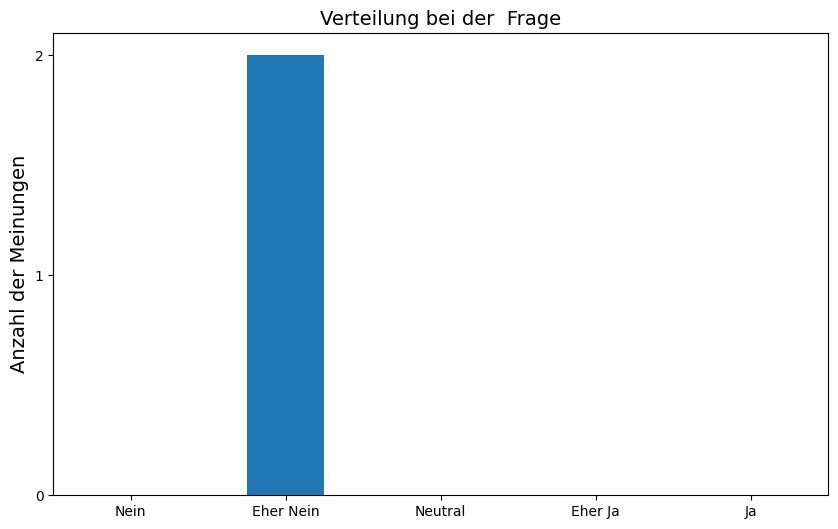

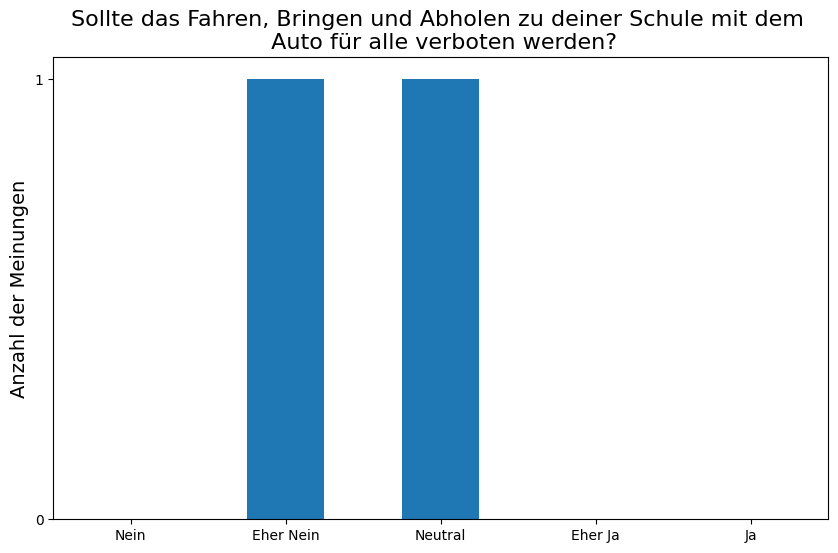

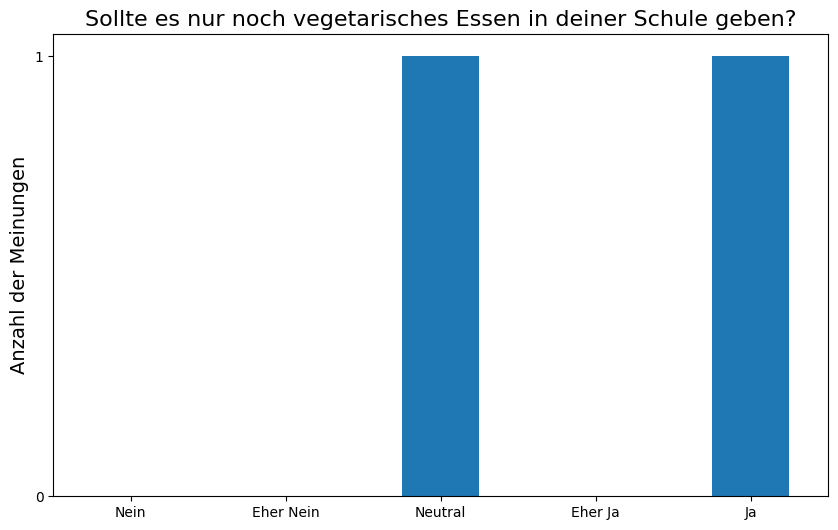

In [85]:
plot_all_distributions(df_flattened)